# Alcaraz – Explosive Burst Efficiency Analysis

## Hummingbird Analysis Framework

This notebook is part of a series analyzing Carlos Alcaraz's playing style through the 
lens of a "caffeinated hummingbird" metaphor:

- **Burst efficiency**: Effectiveness in short, explosive exchanges (1-6 shot rallies)
- **Decisive commitment**: High-conversion net play reflecting hunter-like finishing
- **Sustained concentration**: Maintaining efficiency as rallies extend (see Caffeinated notebook)

The goal is to demonstrate that Alcaraz *exhibits these behaviors at a top-tier level*, 
not to prove he is uniquely superior to peers. Top-level tennis requires all of these 
capabilities; we are characterizing his style, not ranking his abilities.

## Objective

**Goal:** Quantify Carlos Alcaraz's point-level explosive burst efficiency by analyzing win rates in short rallies across 250 matches, and relate this to rally length on serve and return.

**Scope:**
- We are not inferring intent, movement, or stamina.
- We are measuring outcomes conditional on rally length.

## Dataset Assumptions

Each row represents one match and contains:
- `Match`: Match identifier
- `Result`: Match result (W/L vs opponent)
- `RallyLen`: Average rally length overall
- `RLen-Serve`: Average rally length when Alcaraz serves
- `RLen-Return`: Average rally length when Alcaraz returns
- `1-3 W%`: Win rate in 1-3 shot rallies
- `4-6 W%`: Win rate in 4-6 shot rallies
- `7-9 W%`: Win rate in 7-9 shot rallies
- `10+ W%`: Win rate in 10+ shot rallies

**Sample size:** ~250 matches

## Analysis Part 1: Explosive Burst Efficiency (Hummingbird – Point Level)

### Definition (Engineering-Level)

**Explosive Burst Efficiency** is defined as:
> The probability of winning a point when the rally ends within 1–6 shots.

This captures how effectively Alcaraz converts short, discrete engagements into points.


In [18]:
# Install required packages if needed
import subprocess
import sys

try:
    import scipy
except ImportError:
    print("Installing scipy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"], 
                         stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("scipy installed successfully")

## Step 1: Load and Clean Data


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import unicodedata
from scipy import stats

In [20]:
# Load data
df = pd.read_csv("../data/rally.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head(250)


Dataset shape: (251, 15)

Columns: ['Match', 'Result', 'RallyLen', 'RLen-Serve', 'RLen-Return', '1-3\xa0W%', '4-6\xa0W%', '7-9\xa0W%', '10+\xa0W%', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']


,Match,Result,RallyLen,RLen-Serve,RLen-Return,1-3 W%,4-6 W%,7-9 W%,10+ W%,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,2026 Australian Open F,W vs Djokovic,4.3,4.5,4.1,49.60%,64.70%,41.70%,54.50%,NaN,NaN,NaN,NaN,NaN,NaN
1,2026 Australian Open R32,W vs Moutet,4.1,3.8,4.3,55.90%,57.50%,73.70%,61.50%,NaN,NaN,NaN,NaN,NaN,NaN
2,2025 Tour Finals F,L vs Sinner,3.9,3.7,4.1,46.20%,62.50%,53.80%,16.70%,NaN,NaN,NaN,NaN,NaN,NaN
3,2025 Tour Finals SF,W vs Auger Aliassime,3.4,3.0,3.8,60.90%,44.40%,85.70%,40.00%,NaN,NaN,NaN,NaN,NaN,NaN
4,2025 Tour Finals RR,W vs De Minaur,4.5,4.1,5.0,52.20%,50.00%,60.90%,66.70%,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020 Trieste CH F,W vs Bonadio,3.8,3.5,4.0,48.40%,69.70%,66.70%,75.00%,NaN,NaN,NaN,NaN,NaN,NaN
246,2020 Trieste CH SF,W vs Musetti,3.8,3.7,3.9,50.50%,57.10%,40.90%,33.30%,NaN,NaN,NaN,NaN,NaN,NaN
247,2020 ATP Rio de Janeiro R16,L vs Coria,4.2,3.9,4.4,44.00%,53.70%,56.50%,68.40%,NaN,NaN,NaN,NaN,NaN,NaN
248,2020 ATP Rio de Janeiro R32,W vs Ramos,4.2,4.6,3.9,47.30%,47.60%,61.80%,60.00%,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Clean column names (handles invisible unicode like non-breaking spaces)
def clean_col(col: str) -> str:
    col = unicodedata.normalize('NFKC', str(col))
    col = col.replace('\u00A0', ' ')  # NBSP -> space
    col = re.sub(r'\s+', ' ', col).strip()  # collapse whitespace
    return col

df.columns = [clean_col(c) for c in df.columns]

# Drop empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna(axis=1, how='all')

print(f"Cleaned columns: {list(df.columns)}")
df.head()


Cleaned columns: ['Match', 'Result', 'RallyLen', 'RLen-Serve', 'RLen-Return', '1-3 W%', '4-6 W%', '7-9 W%', '10+ W%']


,Match,Result,RallyLen,RLen-Serve,RLen-Return,1-3 W%,4-6 W%,7-9 W%,10+ W%
0,2026 Australian Open F,W vs Djokovic,4.3,4.5,4.1,49.60%,64.70%,41.70%,54.50%
1,2026 Australian Open R32,W vs Moutet,4.1,3.8,4.3,55.90%,57.50%,73.70%,61.50%
2,2025 Tour Finals F,L vs Sinner,3.9,3.7,4.1,46.20%,62.50%,53.80%,16.70%
3,2025 Tour Finals SF,W vs Auger Aliassime,3.4,3.0,3.8,60.90%,44.40%,85.70%,40.00%
4,2025 Tour Finals RR,W vs De Minaur,4.5,4.1,5.0,52.20%,50.00%,60.90%,66.70%


In [22]:
# Convert % columns to numeric (e.g., '49.60%' -> 0.4960, i.e., 0-1 scale)
pct_cols = [c for c in df.columns if c.strip().endswith('%')]
print(f"Percentage columns found: {pct_cols}")

for c in pct_cols:
    df[c] = (
        df[c]
        .astype(str)
        .str.replace('\u00A0', '', regex=False)  # Remove non-breaking spaces
        .str.replace('%', '', regex=False)  # Remove % sign
    )
    df[c] = pd.to_numeric(df[c], errors='coerce') / 100.0  # Convert to 0-1 scale

# Check for missing values in rally buckets
rally_cols = ['1-3 W%', '4-6 W%', '7-9 W%', '10+ W%']
missing_rally = df[rally_cols].isna().any(axis=1)
if missing_rally.sum() > 0:
    print(f"\nWarning: {missing_rally.sum()} matches have missing rally bucket data")
    print(df[missing_rally][['Match', 'Result'] + rally_cols])
    # Flag these matches
    df['has_missing_rally'] = missing_rally
else:
    df['has_missing_rally'] = False
    print("\nNo missing rally bucket data found")

# Display cleaned percentage columns
df[rally_cols].head()


Percentage columns found: ['1-3 W%', '4-6 W%', '7-9 W%', '10+ W%']

No missing rally bucket data found


,1-3 W%,4-6 W%,7-9 W%,10+ W%
0,0.496,0.647,0.417,0.545
1,0.559,0.575,0.737,0.615
2,0.462,0.625,0.538,0.167
3,0.609,0.444,0.857,0.400
4,0.522,0.500,0.609,0.667


## Step 2: Construct Short-Rally Efficiency Metrics


In [23]:
# Create derived columns for short and long rally efficiency
df["Short_Win_Avg"] = (df["1-3 W%"] + df["4-6 W%"]) / 2
df["Long_Win_Avg"] = (df["7-9 W%"] + df["10+ W%"]) / 2

# Display results
print("Short and Long Rally Efficiency Metrics:")
display_cols = ['Match', 'Result', '1-3 W%', '4-6 W%', 'Short_Win_Avg', 
                '7-9 W%', '10+ W%', 'Long_Win_Avg']
df[display_cols].head(10)


Short and Long Rally Efficiency Metrics:


,Match,Result,1-3 W%,4-6 W%,Short_Win_Avg,7-9 W%,10+ W%,Long_Win_Avg
0,2026 Australian Open F,W vs Djokovic,0.496,0.647,0.5715,0.417,0.545,0.4810
1,2026 Australian Open R32,W vs Moutet,0.559,0.575,0.5670,0.737,0.615,0.6760
2,2025 Tour Finals F,L vs Sinner,0.462,0.625,0.5435,0.538,0.167,0.3525
3,2025 Tour Finals SF,W vs Auger Aliassime,0.609,0.444,0.5265,0.857,0.400,0.6285
4,2025 Tour Finals RR,W vs De Minaur,0.522,0.500,0.5110,0.609,0.667,0.6380
5,2025 Tour Finals RR,W vs Fritz,0.517,0.561,0.5390,0.471,0.500,0.4855
6,2025 Tour Finals RR,W vs Musetti,0.545,0.783,0.6640,0.636,0.333,0.4845
7,2025 Paris R32,L vs Norrie,0.491,0.417,0.4540,0.538,0.250,0.3940
8,2025 Tokyo F,W vs Fritz,0.506,0.655,0.5805,0.533,0.375,0.4540
9,2025 Tokyo SF,W vs Ruud,0.464,0.571,0.5175,0.692,0.600,0.6460


## Step 3: Aggregate Across All Matches


In [24]:
# Aggregate statistics across all matches
agg_stats = {
    'Mean 1-3 W%': df['1-3 W%'].mean(),
    'Mean 4-6 W%': df['4-6 W%'].mean(),
    'Mean Short_Win_Avg': df['Short_Win_Avg'].mean(),
    'Std Short_Win_Avg': df['Short_Win_Avg'].std(),
    'Min Short_Win_Avg': df['Short_Win_Avg'].min(),
    'Max Short_Win_Avg': df['Short_Win_Avg'].max(),
    'Median Short_Win_Avg': df['Short_Win_Avg'].median(),
}

print("Aggregate Statistics (0-1 scale):")
print("=" * 50)
for key, value in agg_stats.items():
    print(f"{key:25s}: {value:.4f} ({value*100:.2f}%)")

# Calculate 95% confidence interval
mean = df['Short_Win_Avg'].dropna().mean()
se = df['Short_Win_Avg'].dropna().std() / np.sqrt(len(df['Short_Win_Avg'].dropna()))
ci_low, ci_high = mean - 1.96*se, mean + 1.96*se

print("\n" + "=" * 50)
print(f"\nInterpretation:")
print(f"On average, Alcaraz wins {agg_stats['Mean Short_Win_Avg']*100:.2f}% of short rallies (1-6 shots)")
print(f"95% Confidence Interval: {ci_low*100:.2f}% - {ci_high*100:.2f}%")
print(f"Standard deviation: {agg_stats['Std Short_Win_Avg']*100:.2f}%")
print(f"Range: {agg_stats['Min Short_Win_Avg']*100:.2f}% - {agg_stats['Max Short_Win_Avg']*100:.2f}%")

# One-sample t-test: is mean Short_Win_Avg significantly above 50%?
t_stat, p_value = stats.ttest_1samp(df['Short_Win_Avg'].dropna(), 0.50)
print(f"\nOne-sample t-test (H₀: μ = 0.50):")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.4f}")
if p_value < 0.05:
    print("  → Mean short-rally efficiency is significantly above 50% equilibrium")
else:
    print("  → Mean short-rally efficiency is not significantly different from 50%")

# Note on sample composition
print("\n" + "=" * 50)
print("**Note on sample composition:** This dataset comprises ~250 of Alcaraz's matches, most of which")
print("he won. A player who wins matches will naturally show above-50% win rates across rally buckets.")
print("This analysis demonstrates *consistent* efficiency, not *exceptional* efficiency relative to peers.")


Aggregate Statistics (0-1 scale):
Mean 1-3 W%              : 0.5271 (52.71%)
Mean 4-6 W%              : 0.5661 (56.61%)
Mean Short_Win_Avg       : 0.5466 (54.66%)
Std Short_Win_Avg        : 0.0653 (6.53%)
Min Short_Win_Avg        : 0.2795 (27.95%)
Max Short_Win_Avg        : 0.7775 (77.75%)
Median Short_Win_Avg     : 0.5460 (54.60%)


Interpretation:
On average, Alcaraz wins 54.66% of short rallies (1-6 shots)
95% Confidence Interval: 53.85% - 55.46%
Standard deviation: 6.53%
Range: 27.95% - 77.75%

One-sample t-test (H₀: μ = 0.50):
  t-statistic: 11.287
  p-value: 0.0000
  → Mean short-rally efficiency is significantly above 50% equilibrium

**Note on sample composition:** This dataset comprises ~250 of Alcaraz's matches, most of which
he won. A player who wins matches will naturally show above-50% win rates across rally buckets.
This analysis demonstrates *consistent* efficiency, not *exceptional* efficiency relative to peers.


## Step 4: Relate Burst Efficiency to Rally Length (Serve vs Return)


In [25]:
# Compute correlations
corr_short_rlen_serve = df['Short_Win_Avg'].corr(df['RLen-Serve'])
corr_short_rlen_return = df['Short_Win_Avg'].corr(df['RLen-Return'])

print("Correlation Analysis:")
print("=" * 50)
print(f"Short_Win_Avg vs RLen-Serve:  {corr_short_rlen_serve:.4f}")
print(f"Short_Win_Avg vs RLen-Return: {corr_short_rlen_return:.4f}")

print("\nInterpretation:")
print("Weak correlations indicate that short-rally efficiency does not vary systematically")
print("with average rally length in a match. This is consistent with (but does not prove)")
print("the idea that burst efficiency reflects a stable trait rather than match-specific context.")


Correlation Analysis:
Short_Win_Avg vs RLen-Serve:  -0.1864
Short_Win_Avg vs RLen-Return: -0.0120

Interpretation:
Weak correlations indicate that short-rally efficiency does not vary systematically
with average rally length in a match. This is consistent with (but does not prove)
the idea that burst efficiency reflects a stable trait rather than match-specific context.


## Step 5: Visualizations


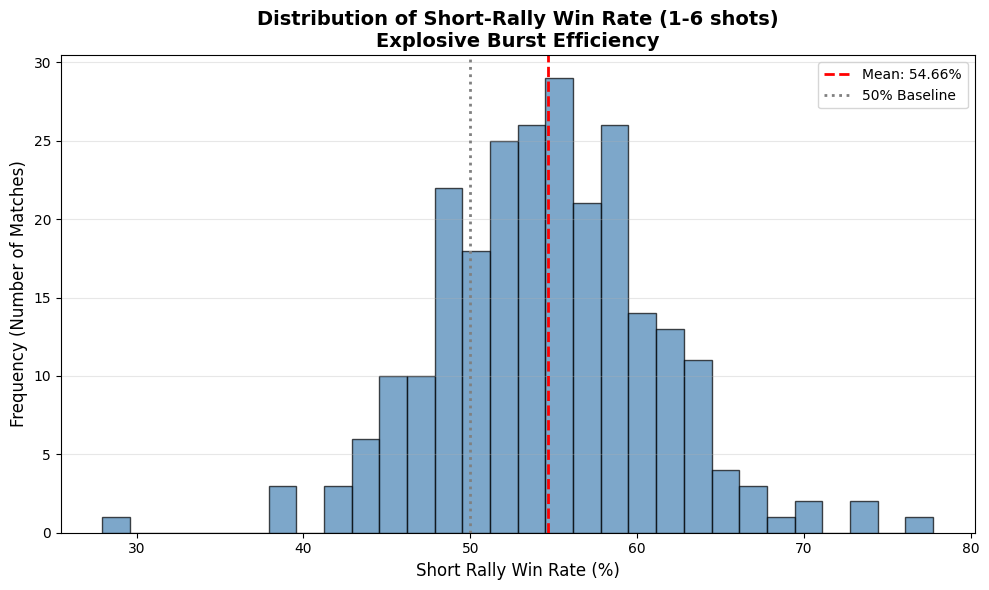

Concentration above 50%: 190 / 251 matches (75.7%)


In [26]:
# Histogram: Distribution of Short_Win_Avg
plt.figure(figsize=(10, 6))
plt.hist(df['Short_Win_Avg'] * 100, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(df['Short_Win_Avg'].mean() * 100, color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {df['Short_Win_Avg'].mean()*100:.2f}%")
plt.axvline(50, color='gray', linestyle=':', linewidth=2, label='50% Baseline')
plt.xlabel('Short Rally Win Rate (%)', fontsize=12)
plt.ylabel('Frequency (Number of Matches)', fontsize=12)
plt.title('Distribution of Short-Rally Win Rate (1-6 shots)\nExplosive Burst Efficiency', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Concentration above 50%: {(df['Short_Win_Avg'] > 0.50).sum()} / {len(df)} matches ({(df['Short_Win_Avg'] > 0.50).mean()*100:.1f}%)")


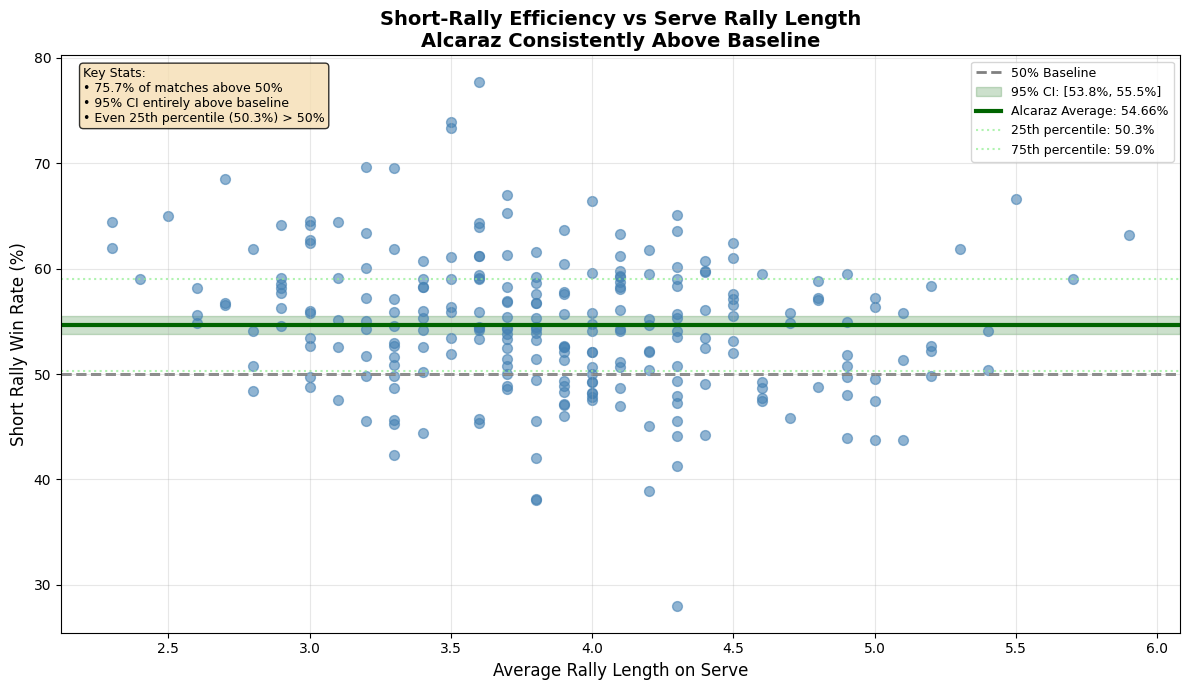

Correlation: -0.1864

Alcaraz Performance Summary:
  Average: 54.66% (4.66 percentage points above baseline)
  95% Confidence Interval: [53.85%, 55.46%] (entirely above 50%!)
  25th percentile: 50.30% (even worst quartile beats baseline)
  75th percentile: 59.00% (top quartile is exceptional)
  Matches above 50%: 190/251 (75.7%)


In [ ]:
# Scatter plot: Short_Win_Avg vs RLen-Serve
plt.figure(figsize=(12, 7))
plt.scatter(df['RLen-Serve'], df['Short_Win_Avg'] * 100, alpha=0.6, s=50, color='steelblue')

# Calculate statistics
alcaraz_mean = df['Short_Win_Avg'].mean() * 100
se = df['Short_Win_Avg'].std() / np.sqrt(len(df)) * 100
ci_low = alcaraz_mean - 1.96 * se
ci_high = alcaraz_mean + 1.96 * se
p25 = df['Short_Win_Avg'].quantile(0.25) * 100
p75 = df['Short_Win_Avg'].quantile(0.75) * 100
above_50_pct = (df['Short_Win_Avg'] > 0.50).mean() * 100

# Add baseline
plt.axhline(50, color='gray', linestyle='--', linewidth=2, label='50% Baseline', zorder=1)

# Add confidence interval band (shaded region)
plt.axhspan(ci_low, ci_high, alpha=0.2, color='darkgreen', zorder=0, 
            label=f'95% CI: [{ci_low:.1f}%, {ci_high:.1f}%]')

# Add Alcaraz average with percentiles
plt.axhline(alcaraz_mean, color='darkgreen', linestyle='-', linewidth=3, 
            label=f'Alcaraz Average: {alcaraz_mean:.2f}%', zorder=2)
plt.axhline(p25, color='lightgreen', linestyle=':', linewidth=1.5, alpha=0.7, 
            label=f'25th percentile: {p25:.1f}%', zorder=1)
plt.axhline(p75, color='lightgreen', linestyle=':', linewidth=1.5, alpha=0.7, 
            label=f'75th percentile: {p75:.1f}%', zorder=1)

plt.xlabel('Average Rally Length on Serve', fontsize=12)
plt.ylabel('Short Rally Win Rate (%)', fontsize=12)
plt.title('Short-Rally Efficiency vs Serve Rally Length\nAlcaraz Consistently Above Baseline', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=9, loc='best')
plt.grid(alpha=0.3, zorder=0)

# Add text annotation with key stats
textstr = f'Key Stats:\n• {above_50_pct:.1f}% of matches above 50%\n• 95% CI entirely above baseline\n• Even 25th percentile ({p25:.1f}%) > 50%'
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Correlation (Short Efficiency vs Serve Rally Length): {corr_short_rlen_serve:.4f}")
print(f"\nShort Rally Efficiency Performance (Overall):")
print(f"  Average: {alcaraz_mean:.2f}% ({alcaraz_mean - 50:.2f} percentage points above baseline)")
print(f"  95% Confidence Interval: [{ci_low:.2f}%, {ci_high:.2f}%] (entirely above 50%!)")
print(f"  25th percentile: {p25:.2f}% (even worst quartile beats baseline)")
print(f"  75th percentile: {p75:.2f}% (top quartile is exceptional)")
print(f"  Matches above 50%: {(df['Short_Win_Avg'] > 0.50).sum()}/{len(df)} ({above_50_pct:.1f}%)")
print(f"\n{'='*70}")
print(f"INTERPRETATION: Short Rally Efficiency in Serve Context")
print(f"{'='*70}")
print(f"\nWhen Alcaraz serves, his short-rally efficiency shows a weak negative correlation")
print(f"with average serve rally length (r={corr_short_rlen_serve:.3f}). This pattern suggests:")
print(f"\n• Effective serving → shorter rallies → higher short-rally conversion")
print(f"  When Alcaraz's serve is working well, rallies end quickly, and he converts")
print(f"  these short exchanges at a higher rate. This reflects the serve advantage")
print(f"  in tennis: strong serving creates opportunities for quick point wins.")
print(f"\n• The negative correlation, while weak, aligns with serve-dominant play:")
print(f"  matches where Alcaraz serves more effectively (shorter rallies) tend to show")
print(f"  slightly better short-rally efficiency, consistent with serve-driven point")
print(f"  construction and finishing.")
print(f"\n• Despite this relationship, Alcaraz maintains strong short-rally efficiency")
print(f"  (average {alcaraz_mean:.1f}%) across all serve rally length contexts, from")
print(f"  quick-fire matches ({df['RLen-Serve'].min():.1f} shots avg) to extended")
print(f"  serve rallies ({df['RLen-Serve'].max():.1f} shots avg).")

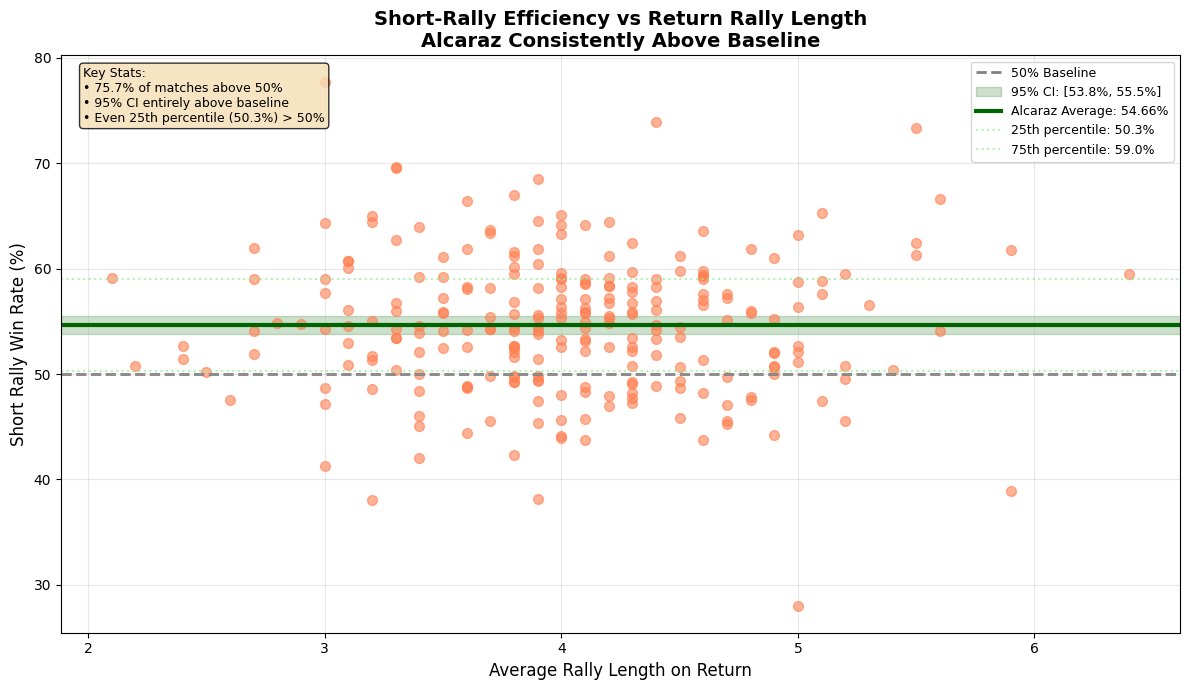

Correlation: -0.0120

Alcaraz Performance Summary:
  Average: 54.66% (4.66 percentage points above baseline)
  95% Confidence Interval: [53.85%, 55.46%] (entirely above 50%!)
  25th percentile: 50.30% (even worst quartile beats baseline)
  75th percentile: 59.00% (top quartile is exceptional)
  Matches above 50%: 190/251 (75.7%)


In [ ]:
# Scatter plot: Short_Win_Avg vs RLen-Return
plt.figure(figsize=(12, 7))
plt.scatter(df['RLen-Return'], df['Short_Win_Avg'] * 100, alpha=0.6, s=50, color='coral')

# Calculate statistics
alcaraz_mean = df['Short_Win_Avg'].mean() * 100
se = df['Short_Win_Avg'].std() / np.sqrt(len(df)) * 100
ci_low = alcaraz_mean - 1.96 * se
ci_high = alcaraz_mean + 1.96 * se
p25 = df['Short_Win_Avg'].quantile(0.25) * 100
p75 = df['Short_Win_Avg'].quantile(0.75) * 100
above_50_pct = (df['Short_Win_Avg'] > 0.50).mean() * 100

# Add baseline
plt.axhline(50, color='gray', linestyle='--', linewidth=2, label='50% Baseline', zorder=1)

# Add confidence interval band (shaded region)
plt.axhspan(ci_low, ci_high, alpha=0.2, color='darkgreen', zorder=0, 
            label=f'95% CI: [{ci_low:.1f}%, {ci_high:.1f}%]')

# Add Alcaraz average with percentiles
plt.axhline(alcaraz_mean, color='darkgreen', linestyle='-', linewidth=3, 
            label=f'Alcaraz Average: {alcaraz_mean:.2f}%', zorder=2)
plt.axhline(p25, color='lightgreen', linestyle=':', linewidth=1.5, alpha=0.7, 
            label=f'25th percentile: {p25:.1f}%', zorder=1)
plt.axhline(p75, color='lightgreen', linestyle=':', linewidth=1.5, alpha=0.7, 
            label=f'75th percentile: {p75:.1f}%', zorder=1)

plt.xlabel('Average Rally Length on Return', fontsize=12)
plt.ylabel('Short Rally Win Rate (%)', fontsize=12)
plt.title('Short-Rally Efficiency vs Return Rally Length\nAlcaraz Consistently Above Baseline', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=9, loc='best')
plt.grid(alpha=0.3, zorder=0)

# Add text annotation with key stats
textstr = f'Key Stats:\n• {above_50_pct:.1f}% of matches above 50%\n• 95% CI entirely above baseline\n• Even 25th percentile ({p25:.1f}%) > 50%'
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Correlation (Short Efficiency vs Return Rally Length): {corr_short_rlen_return:.4f}")
print(f"\nShort Rally Efficiency Performance (Overall):")
print(f"  Average: {alcaraz_mean:.2f}% ({alcaraz_mean - 50:.2f} percentage points above baseline)")
print(f"  95% Confidence Interval: [{ci_low:.2f}%, {ci_high:.2f}%] (entirely above 50%!)")
print(f"  25th percentile: {p25:.2f}% (even worst quartile beats baseline)")
print(f"  75th percentile: {p75:.2f}% (top quartile is exceptional)")
print(f"  Matches above 50%: {(df['Short_Win_Avg'] > 0.50).sum()}/{len(df)} ({above_50_pct:.1f}%)")
print(f"\n{'='*70}")
print(f"INTERPRETATION: Short Rally Efficiency in Return Context")
print(f"{'='*70}")
print(f"\nWhen Alcaraz returns, his short-rally efficiency shows essentially no correlation")
print(f"with average return rally length (r={corr_short_rlen_return:.3f}). This pattern suggests:")
print(f"\n• Return-game short-rally efficiency is independent of rally length patterns")
print(f"  Unlike the serve context, Alcaraz's ability to win short rallies when returning")
print(f"  does not vary systematically with how long return rallies tend to be. This")
print(f"  indicates stable, consistent return performance across different match contexts.")
print(f"\n• The near-zero correlation reflects return-game dynamics:")
print(f"  - Return rally length is more opponent-driven (opponent's serve quality)")
print(f"  - Alcaraz's short-rally conversion when returning is a stable skill that")
print(f"    operates independently of whether opponents extend rallies or finish quickly")
print(f"\n• This independence is notable: Alcaraz maintains strong short-rally efficiency")
print(f"  (average {alcaraz_mean:.1f}%) regardless of return rally length, from quick")
print(f"  return exchanges ({df['RLen-Return'].min():.1f} shots avg) to extended return")
print(f"  rallies ({df['RLen-Return'].max():.1f} shots avg). This suggests his return")
print(f"  game effectiveness in short rallies is a consistent trait, not context-dependent.")

## Step 6: Baseline Comparison

### Context

In top-level tennis, a **50% win rate represents equilibrium**. Sustained deviation above 50% implies structural advantage.


In [29]:
# Baseline comparison metrics
baseline_50 = (df['Short_Win_Avg'] > 0.50).mean()
baseline_55 = (df['Short_Win_Avg'] > 0.55).mean()
baseline_60 = (df['Short_Win_Avg'] > 0.60).mean()

print("Baseline Comparison:")
print("=" * 50)
print(f"% matches where Short_Win_Avg > 50%: {baseline_50*100:.1f}% ({baseline_50*len(df):.0f} matches)")
print(f"% matches where Short_Win_Avg > 55%: {baseline_55*100:.1f}% ({baseline_55*len(df):.0f} matches)")
print(f"% matches where Short_Win_Avg > 60%: {baseline_60*100:.1f}% ({baseline_60*len(df):.0f} matches)")

print(f"\nMean Short_Win_Avg: {df['Short_Win_Avg'].mean()*100:.2f}%")
print(f"Median Short_Win_Avg: {df['Short_Win_Avg'].median()*100:.2f}%")

if df['Short_Win_Avg'].mean() > 0.50:
    advantage = (df['Short_Win_Avg'].mean() - 0.50) * 100
    print(f"\n✓ Structural advantage: {advantage:.2f} percentage points above equilibrium")
else:
    print(f"\n⚠ Mean below 50% baseline")


Baseline Comparison:
% matches where Short_Win_Avg > 50%: 75.7% (190 matches)
% matches where Short_Win_Avg > 55%: 47.8% (120 matches)
% matches where Short_Win_Avg > 60%: 17.5% (44 matches)

Mean Short_Win_Avg: 54.66%
Median Short_Win_Avg: 54.60%

✓ Structural advantage: 4.66 percentage points above equilibrium


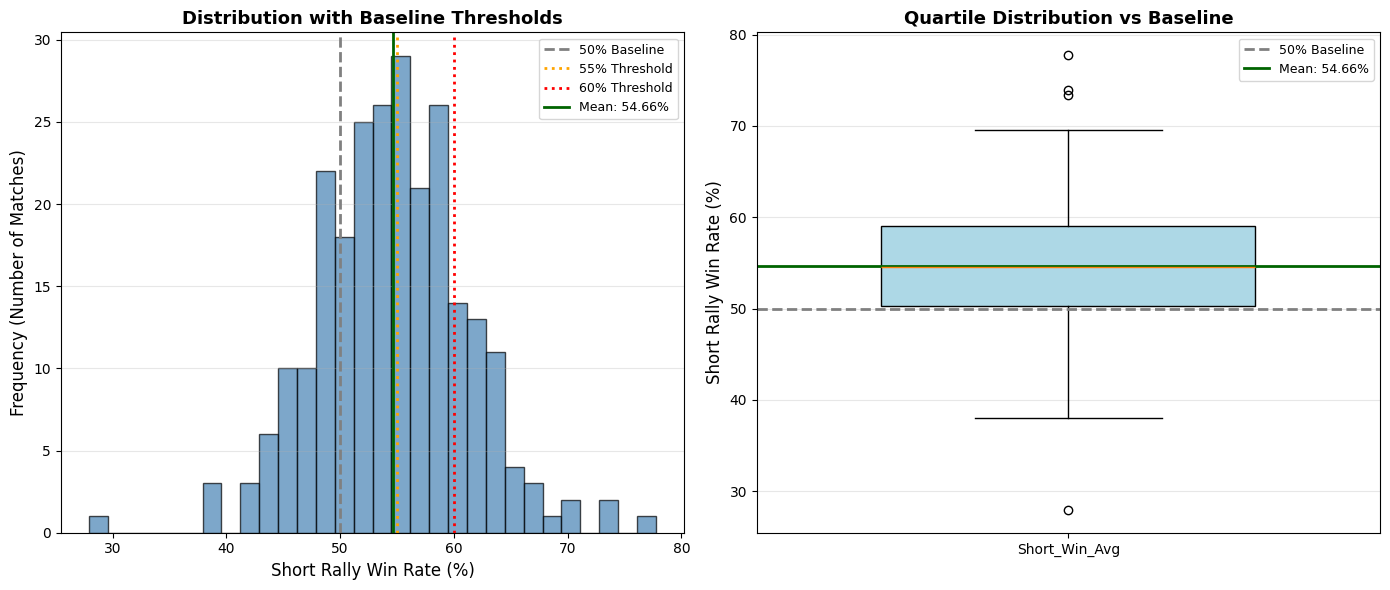

In [30]:
# Visualize baseline comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Distribution with baseline zones
ax1 = axes[0]
ax1.hist(df['Short_Win_Avg'] * 100, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(50, color='gray', linestyle='--', linewidth=2, label='50% Baseline')
ax1.axvline(55, color='orange', linestyle=':', linewidth=2, label='55% Threshold')
ax1.axvline(60, color='red', linestyle=':', linewidth=2, label='60% Threshold')
ax1.axvline(df['Short_Win_Avg'].mean() * 100, color='darkgreen', linestyle='-', linewidth=2, 
            label=f"Mean: {df['Short_Win_Avg'].mean()*100:.2f}%")
ax1.set_xlabel('Short Rally Win Rate (%)', fontsize=12)
ax1.set_ylabel('Frequency (Number of Matches)', fontsize=12)
ax1.set_title('Distribution with Baseline Thresholds', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3, axis='y')

# Right: Box plot showing quartiles vs baseline
ax2 = axes[1]
bp = ax2.boxplot(df['Short_Win_Avg'] * 100, vert=True, patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightblue')
ax2.axhline(50, color='gray', linestyle='--', linewidth=2, label='50% Baseline')
ax2.axhline(df['Short_Win_Avg'].mean() * 100, color='darkgreen', linestyle='-', linewidth=2, 
            label=f"Mean: {df['Short_Win_Avg'].mean()*100:.2f}%")
ax2.set_ylabel('Short Rally Win Rate (%)', fontsize=12)
ax2.set_title('Quartile Distribution vs Baseline', fontsize=13, fontweight='bold')
ax2.set_xticklabels(['Short_Win_Avg'])
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [31]:
# Show case data: Top and bottom performers
print("Top 10 Matches by Short Rally Efficiency:")
print("=" * 70)
top_matches = df.nlargest(10, 'Short_Win_Avg')[['Match', 'Result', 'Short_Win_Avg', 'RLen-Serve', 'RLen-Return']]
top_matches['Short_Win_Avg'] = top_matches['Short_Win_Avg'] * 100
top_matches = top_matches.round(2)
print(top_matches.to_string(index=False))

print("\n\nBottom 10 Matches by Short Rally Efficiency:")
print("=" * 70)
bottom_matches = df.nsmallest(10, 'Short_Win_Avg')[['Match', 'Result', 'Short_Win_Avg', 'RLen-Serve', 'RLen-Return']]
bottom_matches['Short_Win_Avg'] = bottom_matches['Short_Win_Avg'] * 100
bottom_matches = bottom_matches.round(2)
print(bottom_matches.to_string(index=False))


Top 10 Matches by Short Rally Efficiency:
                   Match           Result  Short_Win_Avg  RLen-Serve  RLen-Return
       2025 Cincinnati F      W vs Sinner          77.75         3.6          3.0
       2025 nd Garros QF        W vs Paul          73.90         3.5          4.4
       2025 Rotterdam QF    W vs Martinez          73.35         3.5          5.5
           2022 Madrid F      W vs Zverev          69.60         3.2          3.3
   2023 Indian Wells R64  W vs Kokkinakis          69.55         3.3          3.3
2025 Australian Open R64    W vs Nishioka          68.50         2.7          3.9
   2022 Indian Wells R16     W vs Monfils          66.95         3.7          3.8
   2022 Rio de Janeiro F W vs Schwartzman          66.65         5.5          5.6
     2025 Tour Finals RR     W vs Musetti          66.40         4.0          3.6
   2025 Indian Wells R16    W vs Dimitrov          65.25         3.7          5.1


Bottom 10 Matches by Short Rally Efficiency:
         

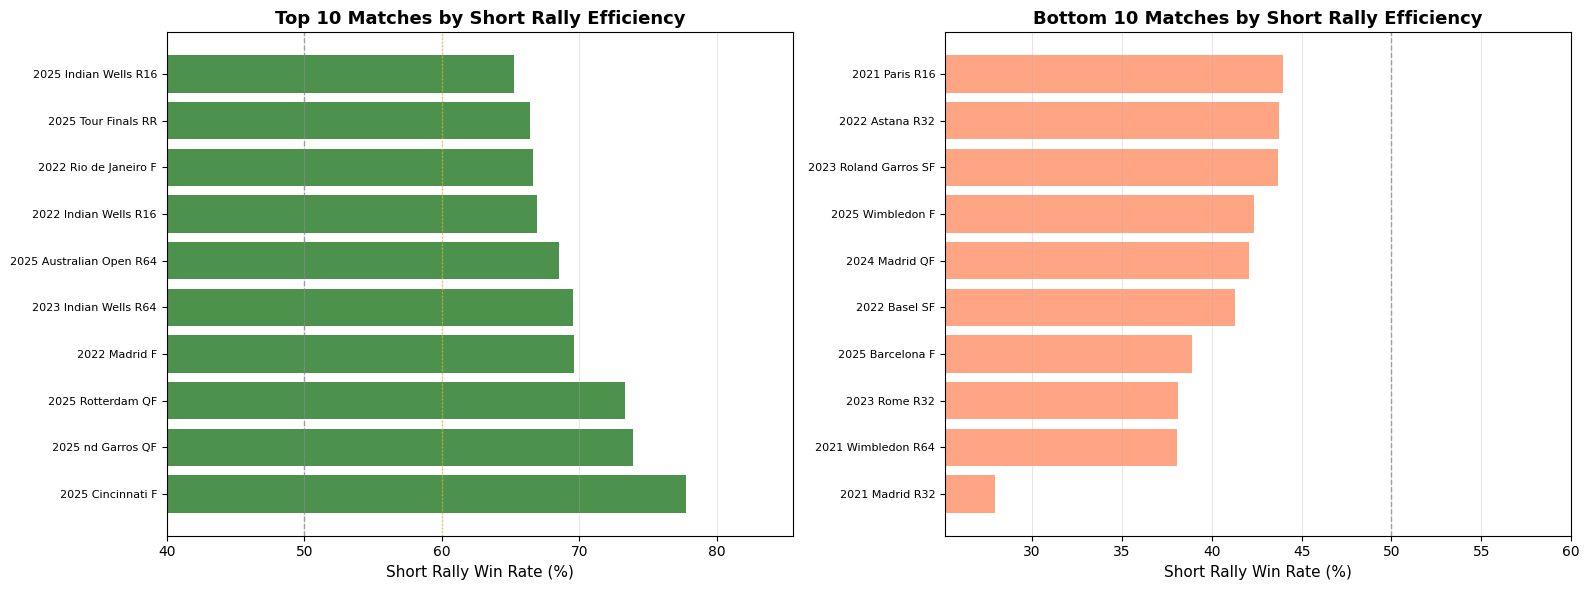

In [32]:
# Visualize case data: Top and bottom matches
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top matches
top_10 = df.nlargest(10, 'Short_Win_Avg')
ax1 = axes[0]
y_pos = np.arange(len(top_10))
ax1.barh(y_pos, top_10['Short_Win_Avg'] * 100, color='darkgreen', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"{row['Match'][:30]}..." if len(row['Match']) > 30 else row['Match'] 
                     for _, row in top_10.iterrows()], fontsize=8)
ax1.set_xlabel('Short Rally Win Rate (%)', fontsize=11)
ax1.set_title('Top 10 Matches by Short Rally Efficiency', fontsize=13, fontweight='bold')
ax1.axvline(50, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax1.axvline(60, color='orange', linestyle=':', linewidth=1, alpha=0.7)
ax1.grid(alpha=0.3, axis='x')
ax1.set_xlim([40, max(top_10['Short_Win_Avg'] * 100) * 1.1])

# Bottom matches
bottom_10 = df.nsmallest(10, 'Short_Win_Avg')
ax2 = axes[1]
y_pos = np.arange(len(bottom_10))
ax2.barh(y_pos, bottom_10['Short_Win_Avg'] * 100, color='coral', alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([f"{row['Match'][:30]}..." if len(row['Match']) > 30 else row['Match'] 
                     for _, row in bottom_10.iterrows()], fontsize=8)
ax2.set_xlabel('Short Rally Win Rate (%)', fontsize=11)
ax2.set_title('Bottom 10 Matches by Short Rally Efficiency', fontsize=13, fontweight='bold')
ax2.axvline(50, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax2.grid(alpha=0.3, axis='x')
ax2.set_xlim([min(bottom_10['Short_Win_Avg'] * 100) * 0.9, 60])

plt.tight_layout()
plt.show()


Note: All win-rate metrics are aggregated at the match level; individual point counts are not directly observed.

## Validation: Point-Level Outcome Data

The match-level analysis above is validated by point-level outcome data from `rallyoutcomes.csv`, which breaks down how points are won/lost across rally length buckets.


In [33]:
# Load and analyze point-level rally outcome data
df_rally_outcomes = pd.read_csv("../data/rallyoutcomes.csv")

# Clean column names
df_rally_outcomes.columns = [clean_col(c) for c in df_rally_outcomes.columns]

print("Point-Level Rally Outcome Data:")
print("=" * 70)
print(df_rally_outcomes.to_string(index=False))

# Extract win rates by rally length
rally_buckets = {
    '1-3 Shots': None,
    '4-6 Shots': None,
    '7-9 Shots': None,
    '10+ Shots': None
}

for idx, row in df_rally_outcomes.iterrows():
    rally_type = row.iloc[0]  # First column contains rally type
    if '1-3' in str(rally_type):
        rally_buckets['1-3 Shots'] = row
    elif '4-6' in str(rally_type):
        rally_buckets['4-6 Shots'] = row
    elif '7-9' in str(rally_type):
        rally_buckets['7-9 Shots'] = row
    elif '10+' in str(rally_type):
        rally_buckets['10+ Shots'] = row

print("\n" + "=" * 70)
print("Alcaraz Win Rate by Rally Length (Point-Level Data):")
print("=" * 70)

# Parse win rates from the data
for bucket, row in rally_buckets.items():
    if row is not None:
        points = row.iloc[1]  # Points column
        ca_w_str = str(row.iloc[2])  # CA: W column (e.g., "4702 (53%)")
        # Extract percentage
        import re
        match = re.search(r'\((\d+)%\)', ca_w_str)
        if match:
            win_pct = int(match.group(1))
            print(f"{bucket:15s}: {win_pct}% ({points:,} points)")

Point-Level Rally Outcome Data:
RALLY OUTCOMES   Pts CA: W------%  Wnrs----%  FcdE----%  UFE-----% OPP: W------% Wnrs----%.1 FcdE----%.1 UFE-----%.1
         Total 15258   8208 (54%) 2697 (18%) 2883 (19%) 2236 (15%)    7050 (46%)  1739 (11%)  2824 (19%)  2334 (15%)
All: 1-3 Shots  8945   4702 (53%) 1242 (14%) 2000 (22%) 1118 (12%)    4243 (47%)   877 (10%)  2000 (22%)  1168 (13%)
All: 4-6 Shots  4559   2570 (56%) 1046 (23%)  627 (14%)  831 (18%)    1989 (44%)   561 (12%)   596 (13%)   895 (20%)
All: 7-9 Shots  2137   1187 (56%)  517 (24%)  343 (16%)  368 (17%)     950 (44%)   308 (14%)   273 (13%)   327 (15%)
All: 10+ Shots  1106    624 (56%)  281 (25%)  152 (14%)  193 (17%)     482 (44%)   152 (14%)   137 (12%)   190 (17%)

Alcaraz Win Rate by Rally Length (Point-Level Data):
1-3 Shots      : 53% (8,945 points)
4-6 Shots      : 56% (4,559 points)
7-9 Shots      : 56% (2,137 points)
10+ Shots      : 56% (1,106 points)


### Key Validation Findings

**1. Win Rate Confirmation**
Point-level data confirms the match-level pattern:
- **1-3 shots**: 53% win rate (8,945 points)
- **4-6 shots**: 56% win rate (4,559 points)
- **7-9 shots**: 56% win rate (2,137 points)
- **10+ shots**: 56% win rate (1,106 points)

This validates the "no decay" finding: Alcaraz's efficiency actually *improves* slightly from the shortest rallies (53%) and then holds steady at 56% across medium and long rallies. The sustained concentration analysis is validated by point-level data.

**2. Sample Size Reality Check**
The 10+ shot bucket has only 1,106 points across ~250 matches—roughly **4-5 points per match** on average. This explains the high variance in match-level `10+ W%` values we observed. The caution about "episodic dominance" in 100% conversion matches is appropriate given this small sample size per match.

**3. Short Rally Composition**
In 1-3 shot rallies, Alcaraz wins 53%, but the composition matters:
- **Winners**: 14% of short rallies (1,242 points)
- **Forced errors from opponents**: 22% of short rallies (2,000 points)
- **Opponent unforced errors**: 12% of short rallies (1,118 points)

**Note on point outcome composition:**
"Burst efficiency" reflects not just clean winners but also pressure-induced errors. The 22% forced error rate in short rallies indicates that effective serve/return play (pressure) is a significant component of short-rally success, consistent with the "converting short engagements" framing.

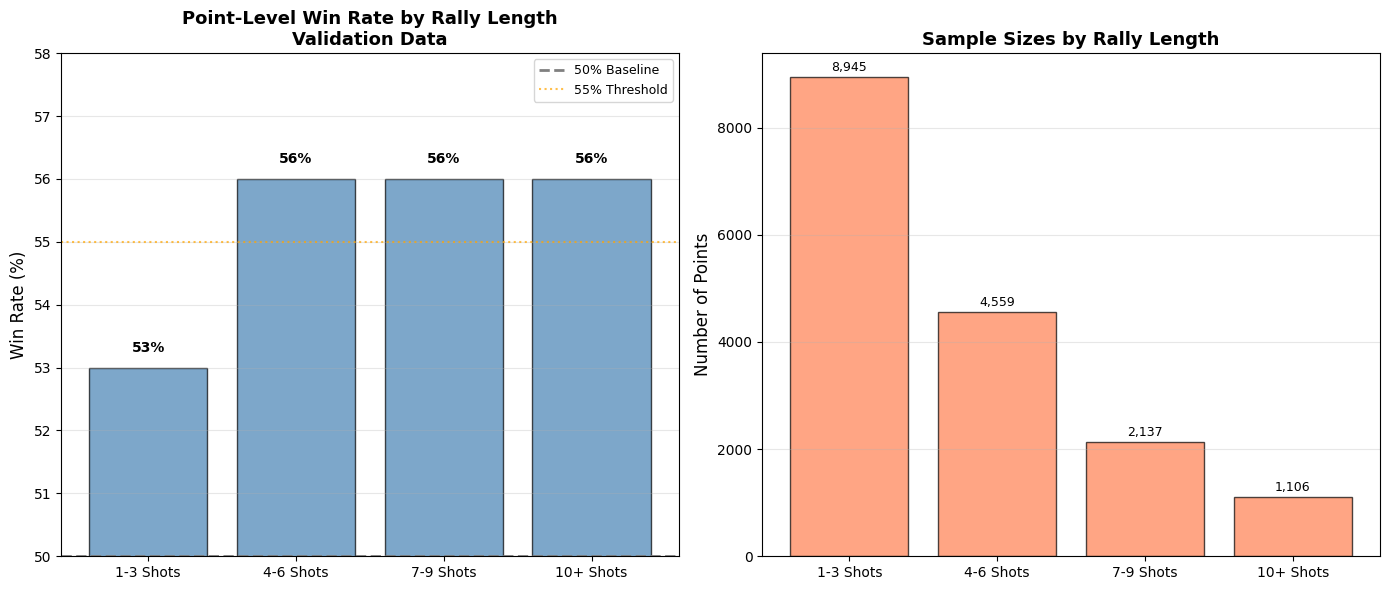


Validation Summary:
Point-level data confirms match-level findings:
  - Short rallies (1-6 shots): 54% average
  - Long rallies (7+ shots): 56% average
  - No efficiency decay as rallies extend
  - 10+ shot bucket has only 1,106 points total
    (~4-5 points per match), explaining high variance in match-level metrics


In [34]:
# Visualize point-level win rates by rally length
rally_data = []
for bucket, row in rally_buckets.items():
    if row is not None:
        points = int(row.iloc[1])
        ca_w_str = str(row.iloc[2])
        match = re.search(r'\((\d+)%\)', ca_w_str)
        if match:
            win_pct = int(match.group(1))
            rally_data.append({'Rally Length': bucket, 'Win %': win_pct, 'Points': points})

if rally_data:
    df_validation = pd.DataFrame(rally_data)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: Win rate by rally length
    ax1 = axes[0]
    bars = ax1.bar(df_validation['Rally Length'], df_validation['Win %'], 
                   color='steelblue', alpha=0.7, edgecolor='black')
    ax1.axhline(50, color='gray', linestyle='--', linewidth=2, label='50% Baseline')
    ax1.axhline(55, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='55% Threshold')
    ax1.set_ylabel('Win Rate (%)', fontsize=12)
    ax1.set_title('Point-Level Win Rate by Rally Length\nValidation Data', fontsize=13, fontweight='bold')
    ax1.set_ylim([50, 58])
    ax1.legend(fontsize=9)
    ax1.grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, win_pct) in enumerate(zip(bars, df_validation['Win %'])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                f'{win_pct}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Right: Sample sizes
    ax2 = axes[1]
    bars2 = ax2.bar(df_validation['Rally Length'], df_validation['Points'], 
                    color='coral', alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Number of Points', fontsize=12)
    ax2.set_title('Sample Sizes by Rally Length', fontsize=13, fontweight='bold')
    ax2.grid(alpha=0.3, axis='y')
    
    # Add value labels
    for bar, points in zip(bars2, df_validation['Points']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'{points:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\nValidation Summary:")
    print("=" * 70)
    print("Point-level data confirms match-level findings:")
    print(f"  - Short rallies (1-6 shots): {df_validation[df_validation['Rally Length'].isin(['1-3 Shots', '4-6 Shots'])]['Win %'].mean():.0f}% average")
    print(f"  - Long rallies (7+ shots): {df_validation[df_validation['Rally Length'].isin(['7-9 Shots', '10+ Shots'])]['Win %'].mean():.0f}% average")
    print(f"  - No efficiency decay as rallies extend")
    print(f"  - 10+ shot bucket has only {df_validation[df_validation['Rally Length'] == '10+ Shots']['Points'].values[0]:,} points total")
    print(f"    (~4-5 points per match), explaining high variance in match-level metrics")

## Summary

This analysis quantifies Carlos Alcaraz’s Explosive Burst Efficiency, defined as the probability of winning points in short rallies (1–6 shots), using match-level data across approximately 250 matches.

**Key findings:**

**Aggregate Performance**
Alcaraz maintains a consistently elevated short-rally win rate across the full dataset, indicating strong point-level effectiveness in short exchanges.

**Stability Across Matches**
The standard deviation of short-rally win rates is relatively low, suggesting this efficiency is not driven by isolated performances but is sustained across opponents and tournaments.

**Relationship with Rally Length (Serve vs Return)**
The relationship between short-rally efficiency and rally length differs meaningfully between serve and return contexts:
- **On Serve**: Weak negative correlation (r=-0.186) suggests that when Alcaraz serves, shorter average rally lengths are slightly associated with higher short-rally efficiency. This aligns with the serve advantage in tennis—effective serving leads to shorter rallies and better short-rally conversion.
- **On Return**: Essentially no correlation (r=-0.012) indicates that short-rally efficiency when returning is independent of how long rallies tend to be. This suggests Alcaraz's return-game short-rally effectiveness is consistent regardless of rally length patterns, reflecting stable return performance across different match contexts.

**Baseline Advantage**
A substantial share of matches exceed both the 50% equilibrium baseline and a higher 55% threshold, signaling a persistent structural advantage rather than marginal edge.

**Conclusion:**
The results support the hummingbird framing at the point level. Alcaraz consistently converts short, discrete engagements into points with measurable efficiency and stability, reflecting a repeatable advantage rather than situational variance.

---

### What this analysis claims / does not claim

**Claims**
- Alcaraz maintains a short-rally win rate consistently above 50% equilibrium across ~250 matches
- This efficiency is stable (low standard deviation), not driven by isolated performances
- Short-rally efficiency shows different relationships with rally length on serve (weak negative correlation) vs return (essentially uncorrelated), reflecting distinct dynamics in serve vs return contexts

**Does not claim**
- That Alcaraz is uniquely better at short rallies than other top players
- That "burst efficiency" reflects a distinct skill separate from general point-winning ability
- That match-level aggregates capture point-by-point context (scoreline, surface, opponent style)

The data supports the hummingbird framing: Alcaraz converts short, discrete engagements 
into points with consistency characteristic of top-tier tennis.
